# Coursework - M Level

**GUID - 3043108S** <br>
**Name - Gaurav Singariya**

## TASKS

**TASK 1** - You will be given two files on comments and submissions. This is a subset of Reddit data in json format. <br>
Process the data to conduct network analysis. <br>
In the report:
- Describe how did you aggregate data from two files and organised the data for further processing.
- Explain the data organisation and rationale.
- Summarise the data, which will be useful when you interpret the results.

**TASK 2** - Use the data and create graphs and create visualisation. <br>
In the report:
- Describe the way you use the data for building graphs – What are origin nodes and what are destination nodes.<br>
**Graph Visualisation**
  - Visualisation of the graphs created. Graph for the entire data and zooming in on a part.
  - How do you interpret this data? Can you make any observations about the data?

**TASK 3** - Make an analysis of the network and understand the important properties.
- Study the role of super users in the community ?
- How central are they to the cohesiveness and functioning of the community?
- How users on support communities, as a group behave over time?
- How exclusive super users in the community in their behaviour? What analysis to conduct? Specify the research Questions to consider?

**NOTE**: Suggested Questions - https://pmc.ncbi.nlm.nih.gov/articles/PMC6060304/ <br>
Define metric, provide a short description, pseudo-code to highlight the logic, and the respective interpretation.

**TASK 4** - Open Creativity Tasks - Sentiment Analysis/Spam Analysis ? <br>
Students are encouraged to explore further. It is up to the students to come up with solutions, though engaging in the class would help. <br>
For example:
- Additional research questions you tried to answer in the report
- Exploring the datasets further and discussing methods for modelling quality of data
- Any other ideas you think useful <br>

**Report**
- Structuring & Formatting - 3 Marks
- Articulation of Ideas - 3 Marks
- Creativity in addressing the tasks - 4 Marks

INTERESTING FIELDS
1. URL - Unique URL of the original post
2. ID - Unique ID
3. PARENT_ID
4. CREATED_UTC
5. NAME
6. TITLE
7. AUTHOR
8. BODY
9. NUM_COMMENTS
10. DOWNS
11. UPS
12. LIKES
13. CLICKED
14. SCORE (UPS - DOWNS)

## Import Libraries

In [1]:
import os
import json
import math
import pytz
import random
import zipfile
import numpy as np
import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

import pyLDAvis
import pyLDAvis.lda_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
pd.set_option('display.max_rows', 100)  # Show all rows

## Helper Functions

In [2]:
def readTextData(path):
    data, lineCounter = [], 0
    with open(path, mode = 'r', encoding = 'utf-8') as file:
        for line in file:
            lineCounter += 1
            if(line != '\n'):
                data.append(line.strip())
    return sorted(data), lineCounter

## Unzip Files

In [3]:
zip_file = "zips/InvestmentClub_submissions_refined.zip"
extract_folder = "Data"
required_file = os.path.join(extract_folder, "InvestmentClub_submissions_refined.json")

# Check if the specific file already exists
if not os.path.exists(required_file):
    print("⏳ Required file not found — extracting from zip...")

    if os.path.exists(zip_file):
        with zipfile.ZipFile(zip_file, "r") as zip_ref:
            zip_ref.extractall(extract_folder)
        print(f"✅ Extracted contents to '{extract_folder}'")
    else:
        print(f"❌ Zip file '{zip_file}' not found.")
else:
    print("✅ Required file already present — skipping extraction.")

✅ Required file already present — skipping extraction.


In [4]:
zip_file = "zips/InvestmentClub_comments_refined.zip"
extract_folder = "Data"
required_file = os.path.join(extract_folder, "InvestmentClub_comments_refined.json")

# Check if the specific file already exists
if not os.path.exists(required_file):
    print("⏳ Required file not found — extracting from zip...")

    if os.path.exists(zip_file):
        with zipfile.ZipFile(zip_file, "r") as zip_ref:
            zip_ref.extractall(extract_folder)
        print(f"✅ Extracted contents to '{extract_folder}'")
    else:
        print(f"❌ Zip file '{zip_file}' not found.")
else:
    print("✅ Required file already present — skipping extraction.")


✅ Required file already present — skipping extraction.


## Read Data

In [5]:
# Read the comments's json file
with open("Data/InvestmentClub_comments_refined.json", mode = 'r', encoding = 'utf-8') as file:
    comments = json.load(file)
print(f"Number of Comments: {len(comments)}")

Number of Comments: 22863


In [6]:
# Read the submissions's json file
with open("Data/InvestmentClub_submissions_refined.json", mode = 'r', encoding = 'utf-8') as file:
    submissions = json.load(file)
print(f"Number of Submissions: {len(submissions)}")

Number of Submissions: 18971


In [7]:
# Read Stopword.txt file
stopWords, linesCount = readTextData('Data/stopwordFile.txt')
print(f"Number of Stop Words: {len(stopWords)}")

Number of Stop Words: 733


In [8]:
assert len(stopWords) + 2 * (len(stopWords) - 1) + 1 == linesCount, "There is some issue in the file/code"

In [9]:
# Convert these list to Pandas DataFrame
commentDf, submissionDf = pd.DataFrame(comments), pd.DataFrame(submissions)

## TASK - 1
**Summarize the data for Network Analysis in Task 2**

In [10]:
# Sort commentDf on created_utc
commentDf["created_ts"] = pd.to_datetime(pd.to_numeric(commentDf["created_utc"]), unit = "s", utc = True)
commentDf = commentDf.sort_values(by = "created_ts", ascending = True)

In [11]:
# Sort submissionDf on created_utc
submissionDf["created_ts"] = pd.to_datetime(pd.to_numeric(submissionDf["created_utc"]), unit = "s", utc = True)
submissionDf = submissionDf.sort_values(by = "created_ts", ascending = True)

In [12]:
commentDf['replied_to'] = commentDf['parent_id'].apply(lambda x: 'post' if x.startswith('t3_') else 'user')

# Create a dictionary mapping comment IDs to their respective authors
comment_id_to_author = commentDf.set_index('id')['author'].to_dict()
submission_id_to_author = submissionDf.set_index('id')['author'].to_dict()

# Used - When a comment is made to reply to a comment.
# Function to get the user ID it replied to
def getRepliedToUser(parent_id):
    if parent_id.startswith('t3_'):
        return np.nan  # NA if replying to a post
    return comment_id_to_author.get(parent_id.replace('t1_', ''), np.nan)

# Used - When a comment is made to reply to a post.
# Function to get the user ID the comment is replied to.
def findSubmissionAuthor(parent_id):
    return submission_id_to_author.get(parent_id.replace('t3_', ''), np.nan)

commentDf['replied_to_user'] = commentDf['parent_id'].apply(getRepliedToUser)
commentDf['replied_to_user'] = commentDf.apply(
    lambda row: findSubmissionAuthor(row['parent_id']) if pd.isna(row['replied_to_user']) else row['replied_to_user'], 
    axis = 1
)

commentDf['submission_author'] = commentDf.apply(
    lambda row: row['replied_to_user'] if row['replied_to'] == 'post' else np.nan, 
    axis = 1
)

In [13]:
commentSubmissionDict = {}
Counter = 0
while(True):
    updatesMade = 0
    for row in commentDf.iloc():
        if(row['id'] not in commentSubmissionDict and pd.isna(row['submission_author'])):
            parentId = row['parent_id']
            if(parentId.replace('t1_', '') in commentSubmissionDict):
                commentSubmissionDict[row['id']] = commentSubmissionDict[parentId.replace('t1_', '')]
                updatesMade += 1
        else:
            if(row['id'] not in commentSubmissionDict):
                commentSubmissionDict[row['id']] = row['submission_author']
    Counter += 1
    print(f"Loop Number: {Counter}, Updates made this loop: {updatesMade}") 
    if(updatesMade == 0):
        break

Loop Number: 1, Updates made this loop: 8820
Loop Number: 2, Updates made this loop: 0


In [14]:
userInteractionDf = commentDf[['id', 'author', 'parent_id', 'replied_to', 'replied_to_user', 'submission_author']]
userInteractionDf = userInteractionDf.copy()
userInteractionDf = userInteractionDf.rename(columns = {'id': 'comment_id'})
userInteractionDf = userInteractionDf.rename(columns = {'author': 'comment_author'})

def findSubmissionAuthor(comment_id):
    return commentSubmissionDict.get(comment_id, np.nan)

userInteractionDf['submission_author'] = userInteractionDf.apply(
    lambda row: findSubmissionAuthor(row['comment_id']) if pd.isna(row['submission_author']) else row['submission_author'], 
    axis = 1
)

In [15]:
userInteractionDf

,comment_id,comment_author,parent_id,replied_to,replied_to_user,submission_author
0,c3mvgkg,hobbitskill,t3_p6dut,post,Zurevu,Zurevu
1,c3mvhfc,withacupofcoffee,t1_c3mvgkg,user,hobbitskill,Zurevu
2,c3mw780,hobbitskill,t3_p6dut,post,Zurevu,Zurevu
3,c3mwiu4,Zurevu,t1_c3mw780,user,hobbitskill,Zurevu
4,c3mwngt,AutonomousMonkey,t3_p6jm5,post,AutonomousMonkey,AutonomousMonkey
...,...,...,...,...,...,...
22858,j2f4uul,Zurevu,t3_zwlyan,post,Happy-Car3439,Happy-Car3439
22859,j2fenq1,Aurelian276,t3_zwd9iw,post,WendBack,WendBack
22860,j2fjx9w,Flip-In-StocksGang,t3_z3igew,post,Wheelsonthegreenbus,Wheelsonthegreenbus
22861,j2fl2px,InvestmentClub-ModTeam,t3_10053am,post,Flip-In-StocksGang,Flip-In-StocksGang


In [16]:
userInteractionDf[userInteractionDf['comment_author'] == '[deleted]']

,comment_id,comment_author,parent_id,replied_to,replied_to_user,submission_author
7,c3mxgl3,[deleted],t1_c3mvhfc,user,withacupofcoffee,Zurevu
8,c3my00l,[deleted],t3_p6jm5,post,AutonomousMonkey,AutonomousMonkey
10,c3my0qm,[deleted],t3_p6dut,post,Zurevu,Zurevu
13,c3my5wl,[deleted],t3_p6jm5,post,AutonomousMonkey,AutonomousMonkey
40,c3n3thg,[deleted],t1_c3n1iuh,user,ttg314,ttg314
...,...,...,...,...,...,...
22825,j0yk5zw,[deleted],t3_z4nemz,post,https_Big_T,https_Big_T
22846,j1yptu8,[deleted],t3_zwlyan,post,Happy-Car3439,Happy-Car3439
22847,j1z266a,[deleted],t1_j1yptu8,user,[deleted],Happy-Car3439
22851,j26dm9x,[deleted],t3_zyksfs,post,Dexdrix,Dexdrix


Let's remove these users, otherwise they will created issues later, might distort the network graph

In [17]:
userInteractionDf = userInteractionDf[userInteractionDf['comment_author'] != '[deleted]']
print("Shape of User Interaction dataframe after removing [DELETED] user: ", userInteractionDf.shape)

Shape of User Interaction dataframe after removing [DELETED] user:  (20172, 6)


Shape of User Interaction dataframe before deletion = (22863, 6) <br>
Shape of User Interaction dataframe after deletion = (20172, 6), i.e 22863 - 2691 = 20172

In [18]:
userInteractionDf[userInteractionDf['replied_to_user'] == '[deleted]']

,comment_id,comment_author,parent_id,replied_to,replied_to_user,submission_author
11,c3my2qh,Zurevu,t1_c3my0qm,user,[deleted],Zurevu
15,c3myj28,AutonomousMonkey,t1_c3my5wl,user,[deleted],AutonomousMonkey
31,c3n0ryd,Delepie,t3_p6wz2,post,[deleted],[deleted]
32,c3n10z8,kirbs2001,t3_p6wz2,post,[deleted],[deleted]
34,c3n1fuv,ttg314,t3_p6wz2,post,[deleted],[deleted]
...,...,...,...,...,...,...
22799,iza53t2,InvestmentClub-ModTeam,t3_zf58j6,post,[deleted],[deleted]
22801,izd4k2y,neocoff,t3_yyy015,post,[deleted],[deleted]
22805,j06r03w,InvestmentClub-ModTeam,t3_zlrk6d,post,[deleted],[deleted]
22810,j09ypeu,MemphisKansasBreeze,t3_zmaens,post,[deleted],[deleted]


Let's remove these users, otherwise they will created issues later, might distort the network graph

In [19]:
userInteractionDf = userInteractionDf[userInteractionDf['replied_to_user'] != '[deleted]']
print("Shape of User Interaction dataframe after removing [DELETED] user: ", userInteractionDf.shape)

Shape of User Interaction dataframe after removing [DELETED] user:  (18576, 6)


Shape of User Interaction dataframe before deletion = (20172, 6) <br>
Shape of User Interaction dataframe after deletion = (18576, 6), i.e 20172 - 1596  = 18576

In [20]:
userInteractionDf[userInteractionDf['submission_author'] == '[deleted]']

,comment_id,comment_author,parent_id,replied_to,replied_to_user,submission_author
37,c3n3c3f,skorsak,t1_c3n0ryd,user,Delepie,[deleted]
58,c3n8bu6,Shiftgood,t1_c3n82p1,user,Zurevu,[deleted]
61,c3n8fw2,Zurevu,t1_c3n8bu6,user,Shiftgood,[deleted]
303,c3rt1rs,Elitist_Circle_Jerk,t1_c3rshnp,user,malaygameti,[deleted]
304,c3rt2ph,Elitist_Circle_Jerk,t1_c3rp3g0,user,vkny88,[deleted]
...,...,...,...,...,...,...
21999,iijpj4s,anally_ExpressUrself,t1_igf93zt,user,rifleman209,[deleted]
22004,iijukq9,rifleman209,t1_iijpj4s,user,anally_ExpressUrself,[deleted]
22697,ix03lkq,9bikes,t1_iwz2isz,user,FlyingDutchLady,[deleted]
22798,iza3ikv,Michael_C_Hall_,t1_iza323h,user,twat_muncher,[deleted]


**Note** - I'm choosing not to remove these rows.
 - **Reason** - Although the post got removed, we can still salvage the interaction between two users.

In [21]:
userInteractionDf[userInteractionDf['comment_id'].isna()]

,comment_id,comment_author,parent_id,replied_to,replied_to_user,submission_author


In [22]:
userInteractionDf[userInteractionDf['comment_author'].isna()]

,comment_id,comment_author,parent_id,replied_to,replied_to_user,submission_author


In [23]:
userInteractionDf[userInteractionDf['parent_id'].isna()]

,comment_id,comment_author,parent_id,replied_to,replied_to_user,submission_author


In [24]:
userInteractionDf[userInteractionDf['replied_to'].isna()]

,comment_id,comment_author,parent_id,replied_to,replied_to_user,submission_author


In [25]:
userInteractionDf[userInteractionDf['replied_to_user'].isna()]

,comment_id,comment_author,parent_id,replied_to,replied_to_user,submission_author
146,c3pvxel,Hagiology,t1_c3om2mt,user,NaN,NaN


In [26]:
userInteractionDf[userInteractionDf['submission_author'].isna()]

,comment_id,comment_author,parent_id,replied_to,replied_to_user,submission_author
146,c3pvxel,Hagiology,t1_c3om2mt,user,NaN,NaN


In [27]:
userInteractionDf = userInteractionDf[userInteractionDf['replied_to_user'].isna() == False]
print("Shape of User Interaction dataframe after removing NaN user: ", userInteractionDf.shape)

Shape of User Interaction dataframe after removing NaN user:  (18575, 6)


Shape of User Interaction dataframe before deletion = (18576, 6) <br>
Shape of User Interaction dataframe after deletion = (18575, 6), i.e 18576 - 1  = 18575

**Summarize the data for Plotting Graphs between Week Number and Number of Submission**

In [28]:
submissionActivityData = submissionDf[["id", "author", "created_ts", "title", "selftext", "num_comments"]]
submissionActivityData = submissionActivityData.rename(columns = {'selftext': 'body'})
submissionActivityData  = submissionActivityData.copy()

In [29]:
commentActivityData = commentDf[["id", "author", "created_ts", "body"]]
commentActivityData  = commentActivityData.copy()

In [30]:
firstWeek = min(submissionActivityData["created_ts"].iloc[0], commentActivityData["created_ts"].iloc[0])

In [31]:
def getWeekNumber(row, firstWeek):
    return (row - firstWeek).days // 7 + 1

In [32]:
submissionActivityData['week_number'] = submissionActivityData.apply(
    lambda row: getWeekNumber(row['created_ts'], firstWeek), axis = 1
)

In [33]:
commentActivityData['week_number'] = commentActivityData.apply(
    lambda row: getWeekNumber(row['created_ts'], firstWeek), axis = 1
)

In [34]:
submissionActivityData

,id,author,created_ts,title,body,num_comments,week_number
11,p6dut,Zurevu,2012-02-01 17:56:21+00:00,Welcome to /r/InvestmentClub!,,23,1
10,p6fpo,bobbyt2012,2012-02-01 18:34:58+00:00,I'll Go First?,,1,1
9,p6jm5,AutonomousMonkey,2012-02-01 19:51:46+00:00,Chesapeake Energy,I'm pitching Chesapeake Energy due to it's gro...,14,1
8,p6ll4,DarkHydra,2012-02-01 20:30:59+00:00,I Like Norfolk Southern And Request You Take a...,I would suggest looking into Norfolk Southern ...,4,1
7,p6mhb,Delepie,2012-02-01 20:48:31+00:00,Synovus Financial Corp (SNV),I've been looking at this stock for a while no...,3,1
...,...,...,...,...,...,...,...
18966,zzp016,Rachel_68,2022-12-31 08:03:11+00:00,RENTING/BUYING PERSONAL INVESTOR DATABASE,[removed],0,570
18967,zztx5h,New-Procedure-3006,2022-12-31 13:16:46+00:00,Earn 5% Profit Daily on Tether USDT Investment...,,0,570
18968,zzvb9q,yukardo,2022-12-31 14:31:05+00:00,High yield dividend stocks,[removed],0,570
18969,1000s3h,diegosere,2022-12-31 18:46:39+00:00,Economic and investment outlook for 2023 by to...,,4,570


In [35]:
commentActivityData

,id,author,created_ts,body,week_number
0,c3mvgkg,hobbitskill,2012-02-01 18:13:16+00:00,I think this is a great idea!,1
1,c3mvhfc,withacupofcoffee,2012-02-01 18:15:16+00:00,what he/she said^!!,1
2,c3mw780,hobbitskill,2012-02-01 19:14:11+00:00,"Which simulator are you going to use, the only...",1
3,c3mwiu4,Zurevu,2012-02-01 19:41:29+00:00,It depends on everybody's vote but I'm guessin...,1
4,c3mwngt,AutonomousMonkey,2012-02-01 19:51:56+00:00,Ticker: CHK,1
...,...,...,...,...,...
22858,j2f4uul,Zurevu,2022-12-31 20:25:52+00:00,Would you mind reposting or crossposting this ...,570
22859,j2fenq1,Aurelian276,2022-12-31 21:37:40+00:00,I share your sentiments. When you invest in so...,570
22860,j2fjx9w,Flip-In-StocksGang,2022-12-31 22:16:22+00:00,POWW,570
22861,j2fl2px,InvestmentClub-ModTeam,2022-12-31 22:24:49+00:00,Your post was removed because it is about a sp...,570


In [36]:
uniqueUsers = set(commentActivityData['author'].unique()) | set(submissionActivityData['author'].unique())
## Subtracting 1, because [deleted] will show up as a User too!!
print("Number of Unique Users in our dataset: ", len(uniqueUsers) - 1)

# Remove [deleted]
uniqueUsers.remove('[deleted]')

Number of Unique Users in our dataset:  12918


In [37]:
## Subtracting 1, because [deleted] will show up as a User too!!
print("Number of Unique Users who commented: ", commentActivityData['author'].nunique() - 1)

Number of Unique Users who commented:  7225


In [38]:
## Subtracting 1, because [deleted] will show up as a User too!!
print("Number of Unique Users who posted: ", submissionActivityData['author'].nunique() - 1)

Number of Unique Users who posted:  6985


In [39]:
usersWhoBothPostedAndCommented = set(commentActivityData['author'].unique()).intersection(set(submissionActivityData['author'].unique()))
## Subtracting 1, because [deleted] will show up as a User too!!
print("Number of Unique Users who posted and commented: ", len(usersWhoBothPostedAndCommented) - 1)

Number of Unique Users who posted and commented:  1292


In [40]:
postsWithReplies = submissionDf[submissionDf['num_comments'] > 0]
print("Number of Posts with Reply: ", len(postsWithReplies))

Number of Posts with Reply:  6251


In [41]:
usersWithMoreThanOnePost = submissionActivityData.groupby("author").size()
usersWithMoreThanOnePost = usersWithMoreThanOnePost[usersWithMoreThanOnePost > 1]
print("Number of Users who posted more than 1 Submissions: ", len(usersWithMoreThanOnePost))

Number of Users who posted more than 1 Submissions:  1553


In [42]:
usersWhoOnlyCommented = set(commentActivityData['author'].unique()) - set(submissionActivityData['author'].unique())
print("No of Users who only commented: ", len(usersWhoOnlyCommented))

No of Users who only commented:  5933


In [43]:
mostActiveUser = commentActivityData["author"].value_counts()
mostActiveUser

author
[deleted]                 2691
Zurevu                    2388
InvestmentClub-ModTeam     125
Jeffbak                     68
StockerFinance              62
                          ... 
halfnerf                     1
Archaia                      1
LordBacall                   1
alaver                       1
Miserable-Ad6949             1
Name: count, Length: 7226, dtype: int64

In [44]:
mostActiveUser = submissionActivityData["author"].value_counts()
mostActiveUser

author
Zurevu              2064
[deleted]           2062
The-Techie           551
Ituglobal            141
AESInternational     127
                    ... 
Bastet1                1
big_dwz                1
Rachel_68              1
diegosere              1
Waterwoo               1
Name: count, Length: 6986, dtype: int64

Summarization of the Data:
- Number of Unique Users: 12918
- Number of Users who both posted & commented: 1292
- Comments to Posts Ratio: 22863/18971 ~ 1.2
- Comments
  - Total Number of Comments: 22863
  - Number of Deleted Comments: 
  - Time Span: 2012-02-01 to 2022-12-31
  - Days/Weeks: 3986/570
  - Number of users who Commented (%): 7225 (56%)
  - No of Users who never Commented (%): 5693 (44%)
  - No of Users who only Commented (%): 5933 (45.92%)
  - Most Active User: Zurevu (with 2388 Comments)
- Submissions
  - Total Number of Submissions: 18971
  - Number of Deleted Submissions: 
  - Time Span: 2012-02-01 to 2022-12-31
  - Days/Weeks: 3986/570
  - No of Posts with Reply (%): 6251 (33%)
  - No of Posts with no Reply (%): 12720 (67%)
  - No of Users who Posted (%): 6985 (54%)
  - No of Users who never Posted (%): 5933 (46%)
  - No of Users who Posted more than 1 Posted (%): 1553 (12%)
  - Most Active User: Zurevu (with 2064 Submissions)

## TASK - 2

In [45]:
# Create a DataFrame for User-User interactions (excluding posts)
graphDf = userInteractionDf[['comment_author', 'replied_to_user']].dropna()
graphDf = graphDf.copy()

# Remove self-loops (users replying to their own submissions)
graphDf = graphDf[graphDf['replied_to_user'] != graphDf['comment_author']]

# replying_user - The user who made the comment (initiating the interaction)
# replied_user - The user being replied to (target of interaction)
graphDf = graphDf.rename(columns = {'comment_author': 'replying_user', 'replied_to_user': 'replied_user'})

userInteractionGraph = nx.from_pandas_edgelist(
    graphDf,
    source = 'replying_user',
    target = 'replied_user',
    create_using = nx.DiGraph()  # Directed graph
)

# Set node sizes (twice the node degree for post authors)
# node_sizes = {node: 2 * userInteractionGraph.degree(node) for node in userInteractionGraph.nodes()}

# Display basic network stats
networkSummary_UIGraph = {
    "Total Nodes (Users)": userInteractionGraph.number_of_nodes(),
    "Total Edges (User-User Interactions)": userInteractionGraph.number_of_edges(),
}
print(networkSummary_UIGraph)

{'Total Nodes (Users)': 8341, 'Total Edges (User-User Interactions)': 14274}


In [46]:
# Create a copy for the complete graph
completeGraph = userInteractionGraph.copy()

# Add missing users as isolated nodes
for user in uniqueUsers:
    if user not in completeGraph:
        completeGraph.add_node(user)

# Display basic network stats
networkSummary_CGraph = {
    "Total Nodes (Users)": completeGraph.number_of_nodes(),
    "Total Edges (User-User Interactions)": completeGraph.number_of_edges(),
}
print(networkSummary_CGraph)

{'Total Nodes (Users)': 12918, 'Total Edges (User-User Interactions)': 14274}


### Full Network Graph

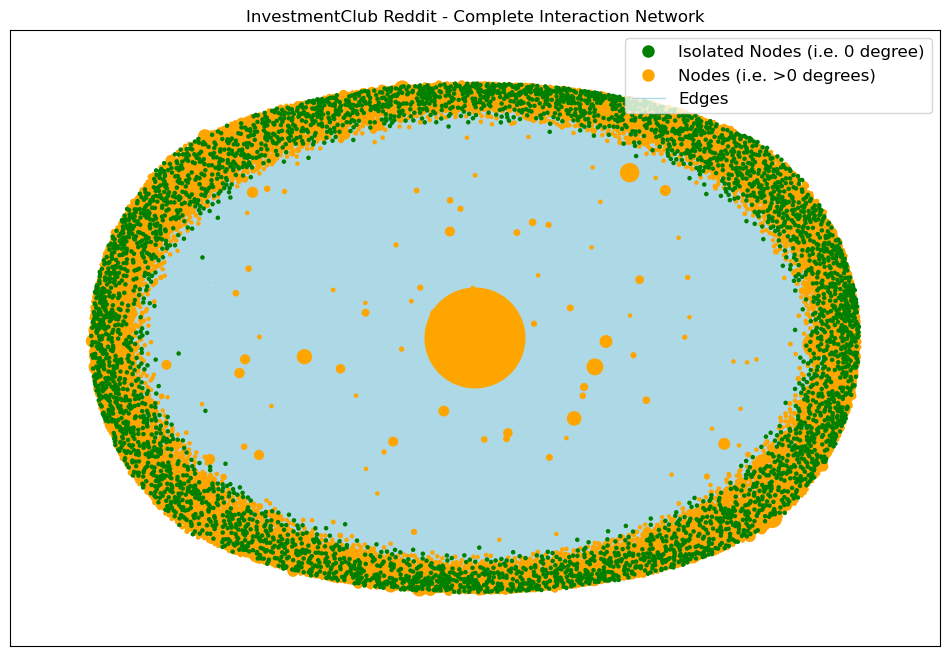

In [47]:
# Calculate node sizes based on degree
nodeSizes = [max(completeGraph.degree(node) * 2, 5) for node in completeGraph.nodes()]

# Create the figure for plotting
plt.figure(figsize = (12, 8))

# Generate positions for the nodes using the spring layout
Positions = nx.spring_layout(completeGraph, seed = 42, k = 0.7)

# Assign node colors: nodes with degree 0 will be red, others will be orange
nodeColors = ['green' if completeGraph.degree(node) == 0 else 'orange' for node in completeGraph.nodes()]

# Draw the network nodes with specified colors
nx.draw_networkx_nodes(completeGraph, Positions, node_size = nodeSizes, alpha = 1.0, node_color = nodeColors)

# Draw the edges with light blue color
nx.draw_networkx_edges(completeGraph, Positions, alpha = 0.5, edge_color = "lightblue", width = 0.5)

# Create custom legend entries
legendElements = [
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'green', markersize = 10, label = "Isolated Nodes (i.e. 0 degree)"),
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'orange', markersize = 10, label = "Nodes (i.e. >0 degrees)"),
    Line2D([0], [0], color = 'lightblue', lw = 1, label = "Edges")
]

# Add the legend to the plot
plt.legend(handles = legendElements, loc = 'upper right', fontsize = 12)

# Add the title and display the plot
plt.title("InvestmentClub Reddit - Complete Interaction Network")
plt.savefig('plots/Complete_Interaction_Graph.png', format='png', bbox_inches='tight')
plt.show()

### User Interaction Graph (i.e. without Isolated Users)

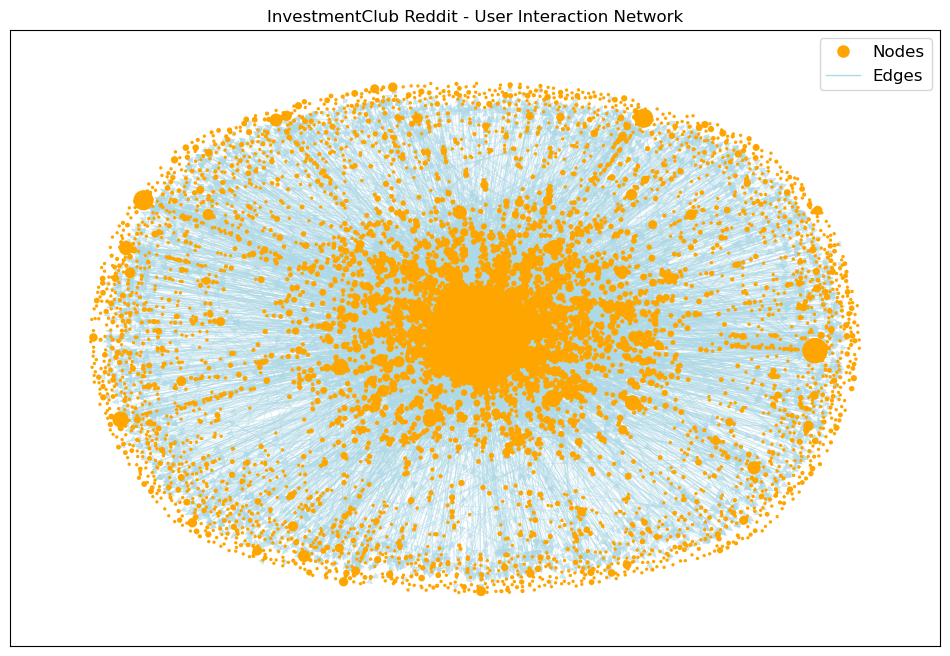

In [48]:
# Calculate node sizes based on degree
nodeSizes = [userInteractionGraph.degree(node) * 2 for node in userInteractionGraph.nodes()]

# Create the figure for plotting
plt.figure(figsize = (12, 8))

# Generate positions for the nodes using the spring layout
Positions = nx.spring_layout(userInteractionGraph, seed = 42)

# Assign node colors: nodes with degree 0 will be red, others will be orange
nodeColors = ['orange' for node in userInteractionGraph.nodes()]

# Draw the network nodes with specified colors
nx.draw_networkx_nodes(userInteractionGraph, Positions, node_size = nodeSizes, alpha = 1.0, node_color = nodeColors)

# Draw the edges with light blue color
nx.draw_networkx_edges(userInteractionGraph, Positions, alpha = 0.5, edge_color = "lightblue", width = 0.5)

# Create custom legend entries
legendElements = [
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'orange', markersize = 10, label = "Nodes"),
    Line2D([0], [0], color = 'lightblue', lw = 1, label = "Edges")
]

# Add the legend to the plot
plt.legend(handles = legendElements, loc = 'upper right', fontsize = 12)

# Add the title and display the plot
plt.title("InvestmentClub Reddit - User Interaction Network")
plt.savefig('plots/User_Interaction_Graph.png', format='png', bbox_inches='tight')
plt.show()

### User Interaction Graph (Top 200 Active Users)

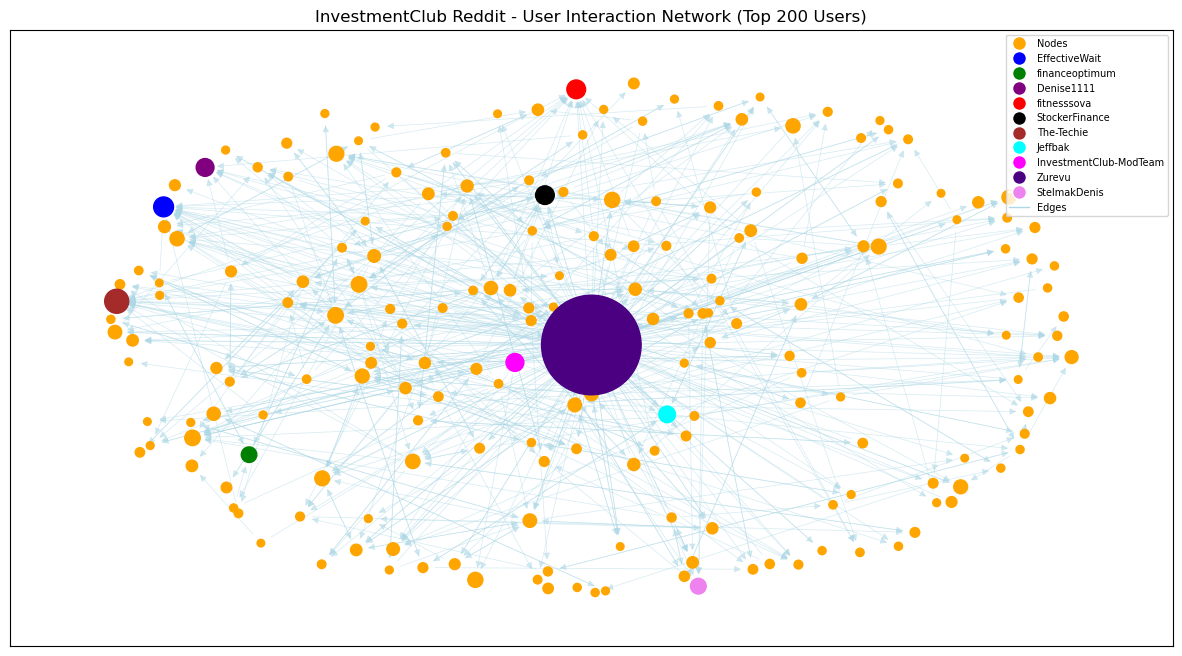

In [49]:
# Sort nodes by degree (top 200 users)
topUsers = sorted(userInteractionGraph.nodes(), key = lambda node: userInteractionGraph.degree(node), reverse = True)[:200]
filteredUserGraph = userInteractionGraph.subgraph(topUsers)

top10Users = topUsers[:10]
# Calculate node sizes based on degree
nodeSizes = [userInteractionGraph.degree(node) * 2 for node in filteredUserGraph]

# Create the figure for plotting
plt.figure(figsize = (15, 8))

# Generate positions for the nodes using the spring layout
Positions = nx.spring_layout(filteredUserGraph, seed = 42, k = 0.7)


colorList = ['blue', 'green', 'purple', 'red', 'black', 'brown', 'cyan', 'magenta', 'indigo', 'violet']
top10UserList = []
nodeColors = []
# Assign top 10 users with different colors
Counter = 0
for node in filteredUserGraph.nodes():
    if node in top10Users:
        # Assign unique color for top 10 users
        nodeColors.append(colorList[Counter])
        top10UserList.append(node)
        Counter += 1
    else:
        nodeColors.append("orange")

# Draw the network nodes with specified colors
nx.draw_networkx_nodes(filteredUserGraph, Positions, node_size = nodeSizes, alpha = 1.0, node_color = nodeColors)

# Draw the edges with light blue color
nx.draw_networkx_edges(filteredUserGraph, Positions, alpha = 0.5, edge_color = "lightblue", width = 0.5)

# Create custom legend entries
legendElements = [
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'orange', markersize = 10, label = "Nodes"),
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = f'{colorList[0]}', markersize = 10, label = f"{top10UserList[0]}"),
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = f'{colorList[1]}', markersize = 10, label = f"{top10UserList[1]}"),
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = f'{colorList[2]}', markersize = 10, label = f"{top10UserList[2]}"),
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = f'{colorList[3]}', markersize = 10, label = f"{top10UserList[3]}"),
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = f'{colorList[4]}', markersize = 10, label = f"{top10UserList[4]}"),
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = f'{colorList[5]}', markersize = 10, label = f"{top10UserList[5]}"),
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = f'{colorList[6]}', markersize = 10, label = f"{top10UserList[6]}"),
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = f'{colorList[7]}', markersize = 10, label = f"{top10UserList[7]}"),
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = f'{colorList[8]}', markersize = 10, label = f"{top10UserList[8]}"),
    Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = f'{colorList[9]}', markersize = 10, label = f"{top10UserList[9]}"),
    Line2D([0], [0], color = 'lightblue', lw = 1, label = "Edges")
]

# Add the legend to the plot
plt.legend(handles = legendElements, loc = 'upper right', fontsize = 7)
# Add the title and display the plot
plt.title("InvestmentClub Reddit - User Interaction Network (Top 200 Users)")
plt.savefig('plots/User_Interaction_Top200_Graph.png', format='png', bbox_inches='tight')
plt.show()

## Task 3

### Activity Analysis

#### For Submissions

##### Cummulative Distibutions of the Number of Posts as a Function of Time (Weeks)

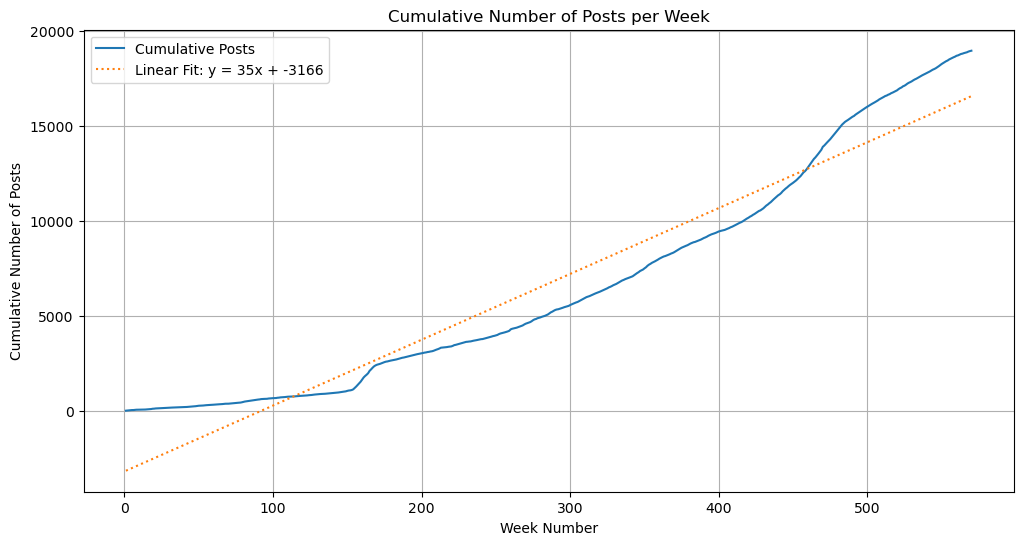

In [50]:
# Compute the weekly post counts
weeklyPostCounts = submissionActivityData["week_number"].value_counts().sort_index()

# Compute the cumulative sum of posts
cumulativePosts = weeklyPostCounts.cumsum()

# Plot the cumulative data
plt.figure(figsize=(12, 6))
plt.plot(cumulativePosts.index, cumulativePosts.values, linestyle='-', label="Cumulative Posts")

# Add a linear fit (dotted line)
x = cumulativePosts.index.values
y = cumulativePosts.values
coeffs = np.polyfit(x, y, 1)  # Linear fit
poly = np.poly1d(coeffs)
plt.plot(x, poly(x), linestyle = ':', label = f"Linear Fit: y = {coeffs[0]:.0f}x + {coeffs[1]:.0f}")

# Labels and title
plt.xlabel("Week Number")
plt.ylabel("Cumulative Number of Posts")
plt.title("Cumulative Number of Posts per Week")

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.savefig('plots/Cumulative_Number_Posts.png', format='png', bbox_inches='tight')
plt.show()

##### Unique User (who made Submission) per Week

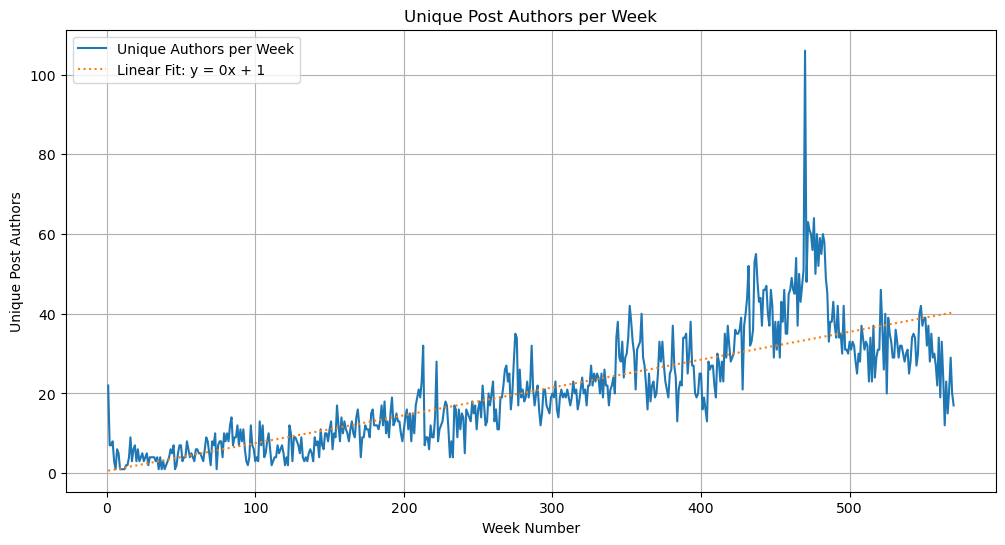

In [51]:
# Compute the unique authors per week
uniqueAuthorsPerWeek = submissionActivityData.groupby("week_number")["author"].nunique()

# Plot the unique authors per week (no cumulative)
plt.figure(figsize=(12, 6))
plt.plot(uniqueAuthorsPerWeek.index, uniqueAuthorsPerWeek.values, linestyle='-', label="Unique Authors per Week")

# Add a linear fit (dotted line)
x = uniqueAuthorsPerWeek.index.values
y = uniqueAuthorsPerWeek.values
coeffs = np.polyfit(x, y, 1)  # Linear fit
poly = np.poly1d(coeffs)
plt.plot(x, poly(x), linestyle=':', label=f"Linear Fit: y = {coeffs[0]:.0f}x + {coeffs[1]:.0f}")

# Labels and title
plt.xlabel("Week Number")
plt.ylabel("Unique Post Authors")
plt.title("Unique Post Authors per Week")

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.savefig('plots/Unique_Post_Authors_Week.png', format='png', bbox_inches='tight')
plt.show()

##### Average Number of Posts per User per Week

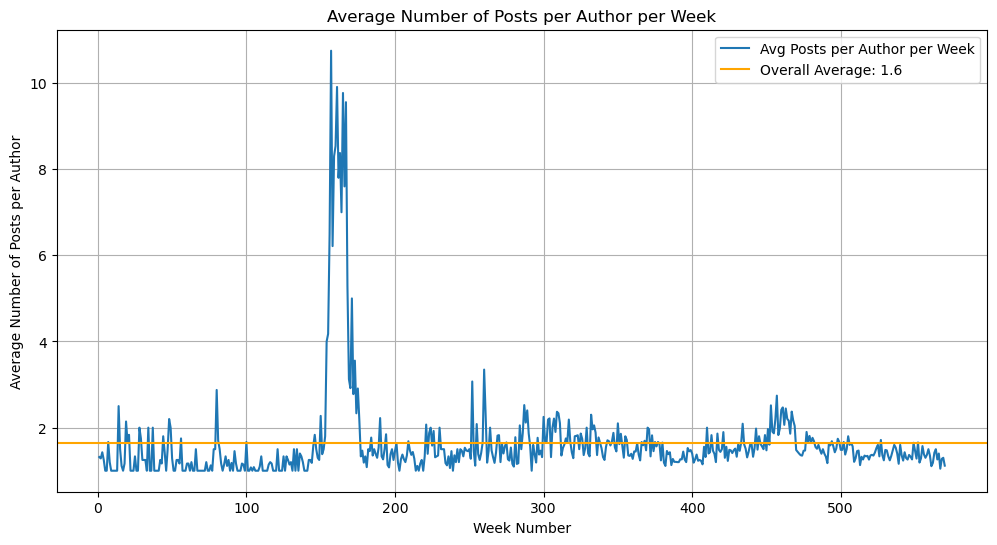

In [52]:
# Compute the unique authors per week
uniqueAuthorsPerWeek = submissionActivityData.groupby("week_number")["author"].nunique()

# Compute the posts per week
postsPerWeek = submissionActivityData["week_number"].value_counts().sort_index()

# Compute the average posts per author per week
averagePostsPerAuthorPerWeek = postsPerWeek / uniqueAuthorsPerWeek

# Compute the overall average across all weeks
averagePostsOverall = averagePostsPerAuthorPerWeek.mean()

# Plot the average posts per author per week
plt.figure(figsize=(12, 6))
plt.plot(averagePostsPerAuthorPerWeek.index, averagePostsPerAuthorPerWeek.values, linestyle='-', label="Avg Posts per Author per Week")

# Plot the horizontal line (overall average)
plt.axhline(y=averagePostsOverall, color='orange', linestyle='-', label=f"Overall Average: {averagePostsOverall:.1f}")

# Labels and title
plt.xlabel("Week Number")
plt.ylabel("Average Number of Posts per Author")
plt.title("Average Number of Posts per Author per Week")

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.savefig('plots/Average_Post_Authors_Week.png', format='png', bbox_inches='tight')
plt.show()

#### For Comments

##### Cummulative Distibutions of the Number of Posts as a Function of Time (Weeks)

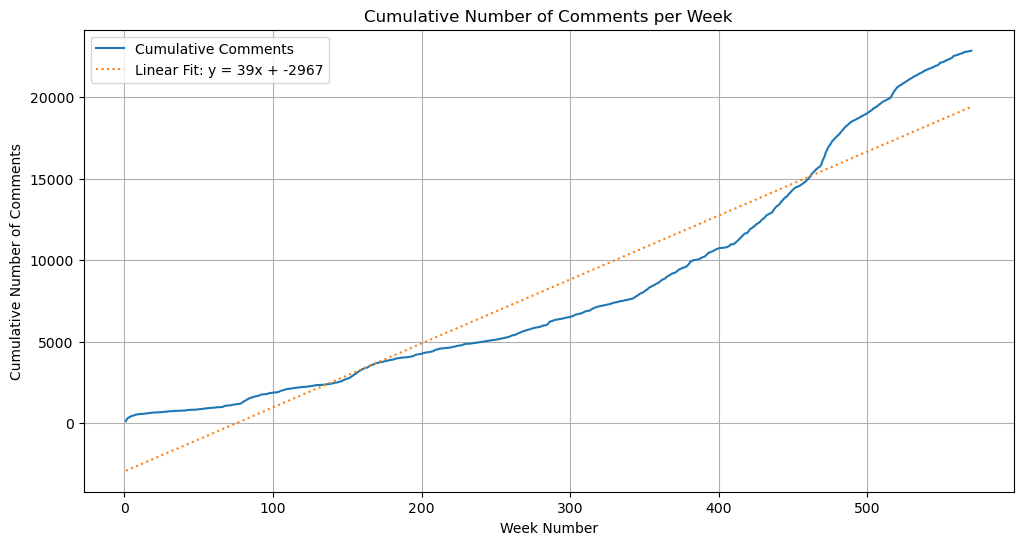

In [53]:
# Compute the weekly post counts
weeklyCommentsCounts = commentActivityData["week_number"].value_counts().sort_index()

# Compute the cumulative sum of posts
cumulativeComments = weeklyCommentsCounts.cumsum()

# Plot the cumulative data
plt.figure(figsize=(12, 6))
plt.plot(cumulativeComments.index, cumulativeComments.values, linestyle = '-', label = "Cumulative Comments")

# Add a linear fit (dotted line)
x = cumulativeComments.index.values
y = cumulativeComments.values
coeffs = np.polyfit(x, y, 1)  # Linear fit
poly = np.poly1d(coeffs)
plt.plot(x, poly(x), linestyle = ':', label = f"Linear Fit: y = {coeffs[0]:.0f}x + {coeffs[1]:.0f}")

# Labels and title
plt.xlabel("Week Number")
plt.ylabel("Cumulative Number of Comments")
plt.title("Cumulative Number of Comments per Week")

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.savefig('plots/Cumulative_Number_Comments.png', format='png', bbox_inches='tight')
plt.show()

##### Unique User (who made Comments) per Week

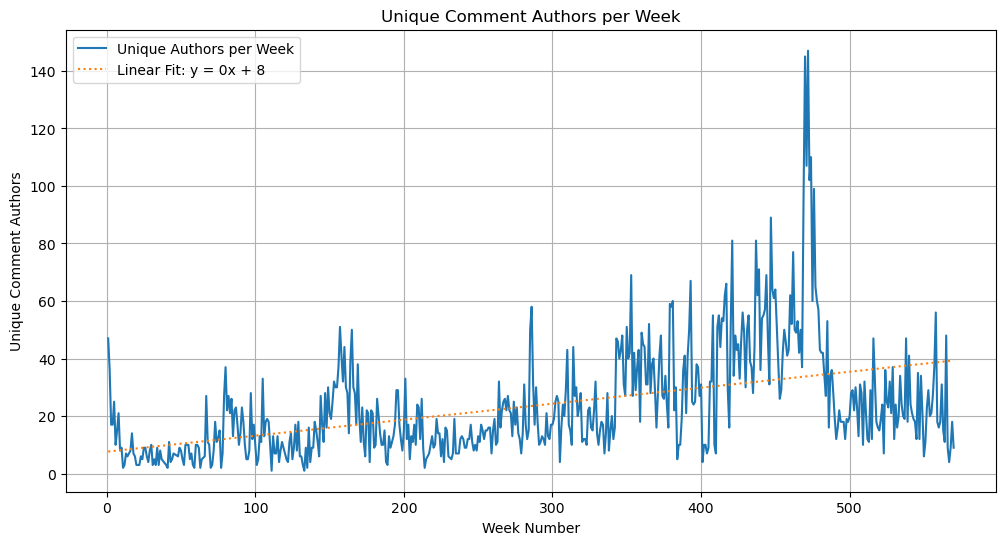

In [54]:
# Compute the unique authors per week
uniqueAuthorsPerWeek = commentActivityData.groupby("week_number")["author"].nunique()

# Plot the unique authors per week (no cumulative)
plt.figure(figsize=(12, 6))
plt.plot(uniqueAuthorsPerWeek.index, uniqueAuthorsPerWeek.values, linestyle='-', label="Unique Authors per Week")

# Add a linear fit (dotted line)
x = uniqueAuthorsPerWeek.index.values
y = uniqueAuthorsPerWeek.values
coeffs = np.polyfit(x, y, 1)  # Linear fit
poly = np.poly1d(coeffs)
plt.plot(x, poly(x), linestyle=':', label=f"Linear Fit: y = {coeffs[0]:.0f}x + {coeffs[1]:.0f}")

# Labels and title
plt.xlabel("Week Number")
plt.ylabel("Unique Comment Authors")
plt.title("Unique Comment Authors per Week")

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.savefig('plots/Unique_Comments_Authors_Week.png', format='png', bbox_inches='tight')
plt.show()

##### Average Number of Comments per User per Week

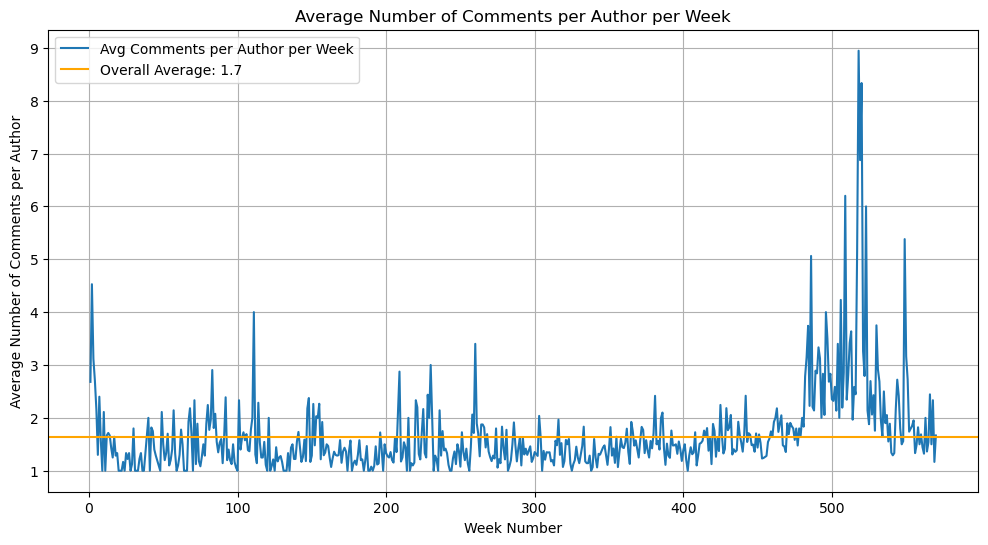

In [55]:
# Compute the unique authors per week
uniqueAuthorsPerWeek = commentActivityData.groupby("week_number")["author"].nunique()

# Compute the posts per week
commentsPerWeek = commentActivityData["week_number"].value_counts().sort_index()

# Compute the average posts per author per week
averageCommentsPerAuthorPerWeek = commentsPerWeek / uniqueAuthorsPerWeek

# Compute the overall average across all weeks
averageCommentsOverall = averageCommentsPerAuthorPerWeek.mean()

# Plot the average posts per author per week
plt.figure(figsize = (12, 6))
plt.plot(averageCommentsPerAuthorPerWeek.index, averageCommentsPerAuthorPerWeek.values, linestyle = '-', label = "Avg Comments per Author per Week")

# Plot the horizontal line (overall average)
plt.axhline(y = averagePostsOverall, color = 'orange', linestyle = '-', label = f"Overall Average: {averageCommentsOverall:.1f}")

# Labels and title
plt.xlabel("Week Number")
plt.ylabel("Average Number of Comments per Author")
plt.title("Average Number of Comments per Author per Week")

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.savefig('plots/Average_Comments_Authors_Week.png', format='png', bbox_inches='tight')
plt.show()

### Identifying Super Users based on Node Degree

In [56]:
degreeCentrality = nx.degree_centrality(userInteractionGraph)
superUsers = sorted(degreeCentrality.items(), key = lambda x: x[1], reverse = True)[:200]
for i in range(0, 10):
    print(superUsers[i])

('Zurevu', 0.3080335731414868)
('The-Techie', 0.017985611510791366)
('EffectiveWait', 0.01223021582733813)
('fitnesssova', 0.01091127098321343)
('StockerFinance', 0.01079136690647482)
('InvestmentClub-ModTeam', 0.009952038369304557)
('Denise1111', 0.009832134292565948)
('Jeffbak', 0.008633093525179856)
('StelmakDenis', 0.007673860911270983)
('financeoptimum', 0.007553956834532374)


### Sensitivity Analysis

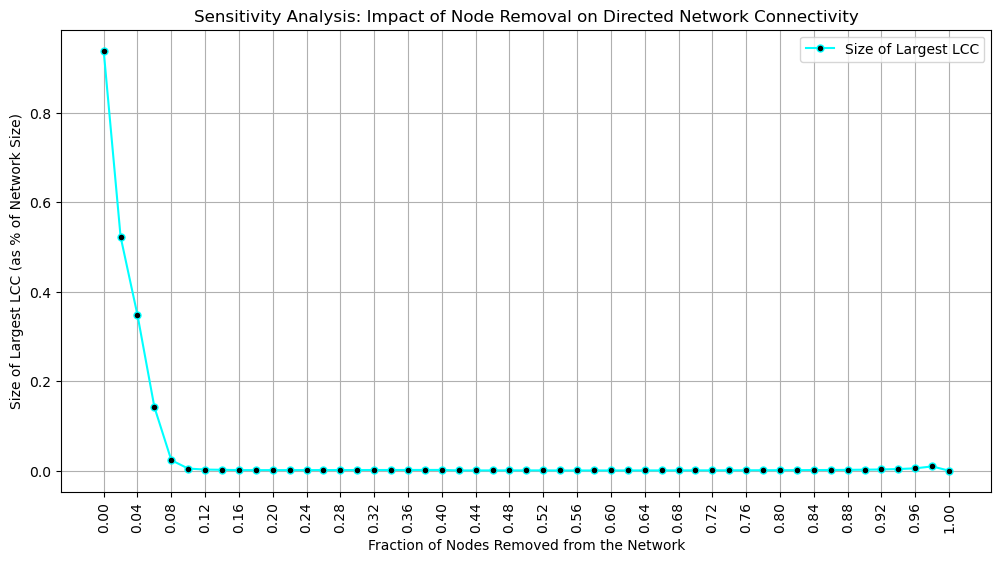

In [57]:
# Copy the directed graph
graph = userInteractionGraph.copy()
graphWithoutZurevu = userInteractionGraph.copy()

# Function to calculate the size of the largest connected component (LCC)
def largest_lcc_size(G):
    # Convert the directed graph to an undirected version to calculate LCC
    G_undirected = G.to_undirected()
    
    # Get the connected components of the graph
    connected_components = list(nx.connected_components(G_undirected))
    
    if len(connected_components) == 0:
        # If there are no connected components, return 0
        return 0
    
    # Find the size of the largest connected component
    largest_lcc = max(connected_components, key=len)
    return len(largest_lcc) / len(G.nodes())

# Get node degrees and sort by degree (most connected nodes first)
sortedNodesByDegree = sorted(graph.nodes(), key=lambda node: graph.degree(node), reverse=True)

# List to store the size of the largest connected component (LCC) after node removal
largestLCCSizes = []

# Initially, the full network
largestLCCSizes.append(largest_lcc_size(graph))

# Define the fraction of nodes to remove at each step
fractionToRemove = 0.02  # 2% nodes

# Remove 1% of nodes progressively and calculate the largest LCC size
totalNodes = len(graph.nodes())
nodesToRemoveAtStep = int(fractionToRemove * totalNodes)
for i in range(1, int(totalNodes / nodesToRemoveAtStep) + 1):
    # If it's the last iteration, remove all remaining nodes
    if i == int(totalNodes / nodesToRemoveAtStep):
        nodesToRemove = sortedNodesByDegree
    else:
        # Remove the top nodes_to_remove_at_step most connected nodes
        nodesToRemove = sortedNodesByDegree[:nodesToRemoveAtStep * i]
    
    graph.remove_nodes_from(nodesToRemove)
    # Calculate the largest connected component size (LCC)
    largestLCCSizes.append(largest_lcc_size(graph))

# Plot the results with dot markers
plt.figure(figsize=(12, 6))
plt.plot(
    np.linspace(0, 1, len(largestLCCSizes)), largestLCCSizes,
    label = "Size of Largest LCC", color = 'cyan', marker = 'o', markersize = 5, markerfacecolor = 'black'
)

# Set x-tick intervals (showing fraction increments: 0.00, 0.04, 0.08, ..., 1.00)
plt.xticks(np.linspace(0, 1, 26), labels=[f'{(i*4)/100:.2f}' for i in range(26)], rotation = 90)

# Add labels and title
plt.xlabel("Fraction of Nodes Removed from the Network")
plt.ylabel("Size of Largest LCC (as % of Network Size)")
plt.title("Sensitivity Analysis: Impact of Node Removal on Directed Network Connectivity")

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.savefig('plots/Sensitivity_Analysis.png', format='png', bbox_inches='tight')
plt.show()

### Rich-Club Effect

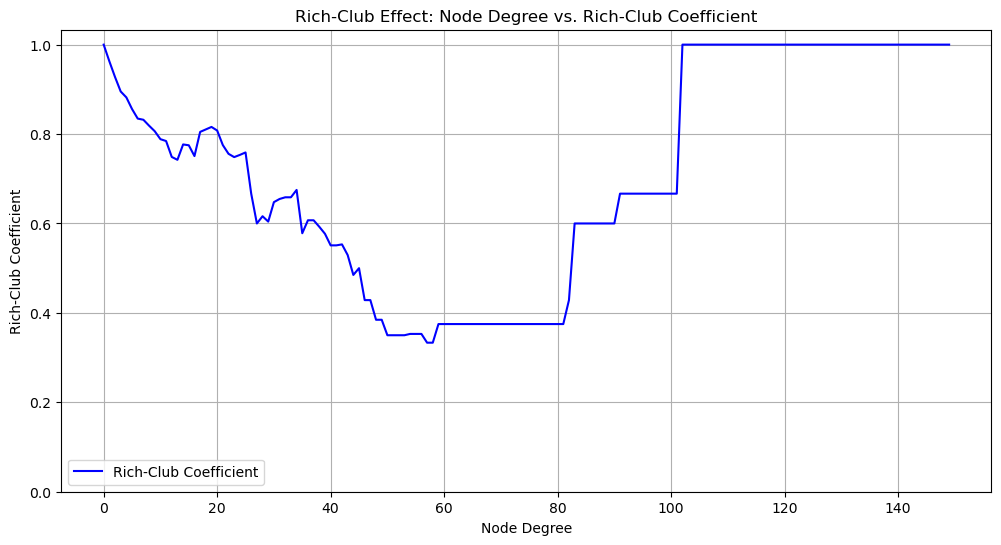

In [58]:
# Assuming 'graph' is your directed graph (userInteractionGraph or similar)
graph = userInteractionGraph.copy()

# Remove self-loops
graph.remove_edges_from(nx.selfloop_edges(graph))

# Convert to an undirected graph for the rich-club coefficient calculation
graphUndirected = graph.to_undirected()

# Calculate the rich-club coefficient
richClubValues = nx.rich_club_coefficient(graphUndirected, normalized = True, seed = 40)

# Extract the degree values and corresponding rich-club coefficients
degrees = sorted(richClubValues.keys())  # Degree values
richClubCoeffs = [richClubValues[k] for k in degrees]

# Plotting the Rich Club Effect
plt.figure(figsize = (12, 6))
plt.plot(degrees, richClubCoeffs, label = "Rich-Club Coefficient", color = 'blue')

# Add labels and title
plt.xlabel("Node Degree")
plt.ylabel("Rich-Club Coefficient")
plt.title("Rich-Club Effect: Node Degree vs. Rich-Club Coefficient")
plt.grid(True)
plt.legend()

# Set the y-axis to start from 0.0
plt.ylim(bottom = 0.0)

# Show the plot
plt.savefig('plots/Rich_Club_Effect_Analysis.png', format='png', bbox_inches='tight')
plt.show()

### Z-Score Analysis

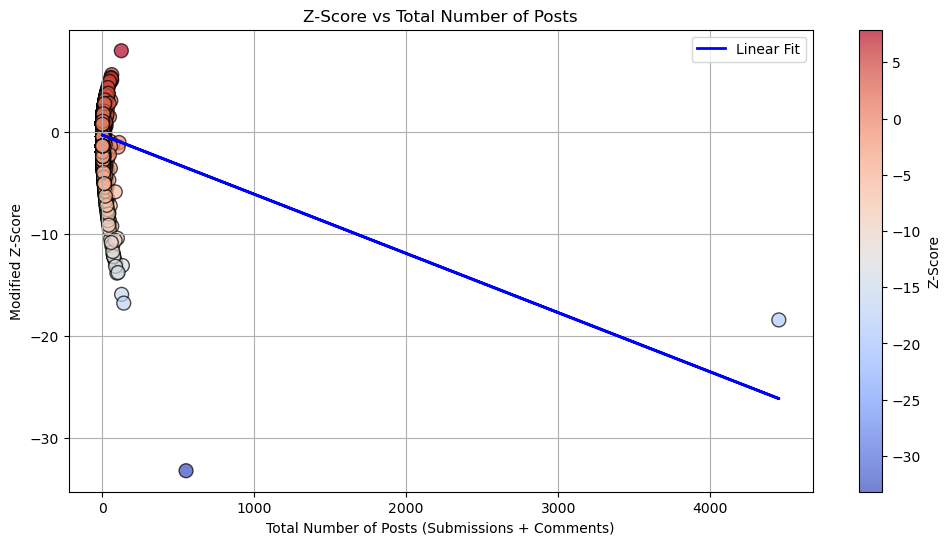

In [59]:
# Remove '[deleted]' users and NaN values from both dataframes
filteredSubmissionActivityData = submissionActivityData[~submissionActivityData['author'].isin(['[deleted]', np.nan])]
filteredCommentActivityData = commentActivityData[~commentActivityData['author'].isin(['[deleted]', np.nan])]

# Count the number of submissions (questions) and comments (answers) per user
submissionCounts = filteredSubmissionActivityData['author'].value_counts()
commentCounts = filteredCommentActivityData['author'].value_counts()

# Merge submission and comment counts on the AUTHOR
userActivity = pd.DataFrame({
    'submissions': submissionCounts,
    'comments': commentCounts
}).fillna(0)  # Fill missing values with 0 for users who may only have submissions or comments

# Calculate total posts (submissions + comments)
userActivity['totalPosts'] = userActivity['submissions'] + userActivity['comments']

# Calculate the Z-score for each user
userActivity['zScore'] = (userActivity['comments'] - 2 * userActivity['submissions']) / np.sqrt(2 * (userActivity['submissions'] + userActivity['comments']))

# Plot the Z-score vs. total posts
plt.figure(figsize=(12, 6))
plt.scatter(userActivity['totalPosts'], userActivity['zScore'], c=userActivity['zScore'], cmap='coolwarm', edgecolor='black', s=100, alpha=0.7)

# Fit a linear regression line
model = LinearRegression()
model.fit(userActivity['totalPosts'].values.reshape(-1, 1), userActivity['zScore'])
predictedZScores = model.predict(userActivity['totalPosts'].values.reshape(-1, 1))

plt.plot(userActivity['totalPosts'], predictedZScores, color='blue', linestyle='-', linewidth=2, label='Linear Fit')

# Add labels and title
plt.xlabel("Total Number of Posts (Submissions + Comments)")
plt.ylabel("Modified Z-Score")
plt.title("Z-Score vs Total Number of Posts")

# Show grid and color bar
plt.grid(True)
plt.colorbar(label='Z-Score')

# Display the plot
plt.legend()
plt.savefig('plots/Z-Score_Analysis.png', format='png', bbox_inches='tight')
plt.show()

In [60]:
print("No of Help Seekers: ", userActivity[userActivity['zScore'] < 0].shape[0])
print("No of Support Givers: ", userActivity[userActivity['zScore'] > 0].shape[0])
print("No of Users who behave as both Help Seekers as well as Support Givers: ", userActivity[userActivity['zScore'] == 0].shape[0])

No of Help Seekers:  6504
No of Support Givers:  6255
No of Users who behave as both Help Seekers as well as Support Givers:  159


## Task 4 - Open Creativity Tasks

### Topic Analysis

In [61]:
lowEngagementSubmissions = submissionActivityData[submissionActivityData['num_comments'] < 5]
lowEngagementSubmissions['num_comments'].value_counts()

print("No of Low Engagement Submissions: ", len(lowEngagementSubmissions))

No of Low Engagement Submissions:  17726


Approximately out of 18971 Submissions, almost 17726 submissions have only received less than 5 comments. We could very well make an assumption that these submissions aren't driving the engagement in the community. <br>

So, we will only focus on Submissions with number of comments 5 or more than 5.

In [62]:
highEngagementSubmissions = submissionActivityData[submissionActivityData['num_comments'] >= 5]
highEngagementSubmissions = highEngagementSubmissions[highEngagementSubmissions['body'] != '[deleted]']
highEngagementSubmissions = highEngagementSubmissions.copy()

In [63]:
# Combine title and selftext into one column for topic analysis
highEngagementSubmissions['full_text'] = highEngagementSubmissions['title'] + " " + highEngagementSubmissions['body']

# Vectorizing the text data
vectorizer = TfidfVectorizer(stop_words = stopWords)
X = vectorizer.fit_transform(highEngagementSubmissions['full_text'])

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components = 5, random_state = 42)  # Set number of topics
lda.fit(X)

# Print top words for each topic
terms = vectorizer.get_feature_names_out()
for index, topic in enumerate(lda.components_):
    print(f"Topic {index}: ", [terms[i] for i in topic.argsort()[-10:]])

D:\Anaconda\envs\cudaEnv\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  warnings.warn(


Topic 0:  ['amp', 'com', 'hi', 'will', 'type', 'deflation', 'investmentclub', 'stock', 'removed', 'mcdonald']
Topic 1:  ['money', 'just', 'buy', 'can', 'market', 'investment', 'investing', 'invest', 'stocks', 'stock']
Topic 2:  ['stock', 'investing', 'apple', '2020', 'billion', 'buffett', 'warren', 'user', 'deleted', 'removed']
Topic 3:  ['oil', 'amazon', 'buy', 'bitcoin', 'recession', 'crash', 'favorite', 'analysis', 'market', 'stock']
Topic 4:  ['new', 'next', 'electric', 'stock', 'apple', 'buy', 'removed', 'market', 'peter', 'bitcoin']


In [64]:
# Prepare the data for pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda, X, vectorizer)
pyLDAvis.display(vis)

### Zurevu

In [65]:
submissionActivityData[submissionActivityData["author"] == "Zurevu"]

,id,author,created_ts,title,body,num_comments,week_number
11,p6dut,Zurevu,2012-02-01 17:56:21+00:00,Welcome to /r/InvestmentClub!,,23,1
28,pgfbh,Zurevu,2012-02-08 16:55:37+00:00,/r/InvestmentClub reminder: Vote for your favo...,,26,1
29,pjmo8,Zurevu,2012-02-10 18:03:41+00:00,/r/InvestmentClub: Voting for our first stock ...,,22,2
33,pny4m,Zurevu,2012-02-13 20:40:20+00:00,/r/InvestmentClub Announcement: We've made our...,"We purchased almost $50,000 worth of [TSLA](ht...",15,2
39,pr9x6,Zurevu,2012-02-15 21:35:28+00:00,"Tesla Motors, Inc. – Fourth Quarter &amp; Full...",,0,3
...,...,...,...,...,...,...,...
18559,xt6yhx,Zurevu,2022-10-01 21:37:36+00:00,Warren Buffett's Berkshire Hathaway has seen $...,,5,557
18588,xwgpyf,Zurevu,2022-10-05 17:26:17+00:00,"Greg Abel, set to be Warren Buffett's successo...",,0,557
18604,xz1qhs,Zurevu,2022-10-08 19:46:34+00:00,These 2 Stocks Make Up 52% of Warren Buffett's...,,5,558
18627,y2i177,Zurevu,2022-10-12 22:47:09+00:00,Hedge Fund Managers Paid for Stockpicking Geni...,,1,559
